# General expressions

## $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent:

\begin{equation}
\label{eq:r_dot_DF_time}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}} \cdot r^{-5/2}\text{.}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and classes

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

In [20]:
class Phase_Evaluation:
    
    def __init__(self, m1, m2, mach, sigma0, gamma, gammas, rho6, r6, epsv, dist): 
        
        self.G = 6.67408e-11 # kg^-1 m^3 / s^2
        self.c = 299792458.0 # m / s
        self.m1 = m1
        self.m2 = m2
        self.M_tot = self.m1 + self.m2
        self.mach = mach
        self.r0 = 6 * self.G * self.m1 / self.c**2 # 3 * r_s
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.sigma0 = sigma0 / self.mach**2
        self.gamma = gamma
        self.logL = 1 / (self.q)**(1/2)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
    
    
    def rho_dm(self, r):
        '''Finds the density profile of the dark matter using the above formulation.'''
        return self.rho0 * (self.r0 / r)**(self.gamma)
    
    def sigma_acc(self, r): 
        return self.sigma0 * (r / self.r0)**(self.gamma)

    def rho_disk(self, r):
        '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
        return self.sigma_acc(self, r) / (2 * r / self.mach) # set h = r / Mach

    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return 1 / np.pi * np.sqrt(self.G * self.m1 / r**3) # m1 not M, corrected from Pippa's notebook
    
    def radius(self, f):
        '''Finds the binary radius assuming circular orbits, at fixed frequency f.'''
        return (self.G * self.M_tot / (np.pi**2 * f**2))**(1/3)

    def df_dr(self, r): 
        '''Finds the binary frequency radial derivative assuming circular orbits.'''
        return 1 / np.pi * (- 3 / 2) * np.sqrt(self.G * self.M_tot / r**5)

    def gas_torque(self, r): 
        return - self.sigma_acc(r) * r**4 * (self.G * self.M_tot / r**3) * self.q**2 * self.mach**2

    def yes_or_no(self, elem):
        '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        if elem=='y': 
            return 1
        return 0

    def dot_r(self, r):
        '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
            
        acc = ''
        dm = ''
        gw = ''
        
        while(acc != 'y' and acc != 'n'):
            print('Include the accretion contribution? (y/n)')
            acc = input()
        
        while(dm != 'y' and dm != 'n'):
            print('Include the dark matter contribution? (y/n)')
            dm = input()
        
        while(gw != 'y' and gw != 'n'):
            print('Include the GW contribution? (y/n)')
            gw = input()
            
        print('-----')
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        
        return self.yes_or_no(acc) * r_dot_acc + self.yes_or_no(dm) * r_dot_dm + self.yes_or_no(gw) * r_dot_gw

    def dot_r_acc(self, r):
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        return r_dot_gw + r_dot_acc
    
    def dot_r_all(self, r):
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        return r_dot_gw + r_dot_dm + r_dot_acc
        
    def dot_r_dm(self, r):
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        
        return r_dot_gw + r_dot_dm
        
        
    def dot_r_gw(self, r):
        
        return - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
    
    
    def df_dt(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r(r)
    
    def df_dt_all(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_all(r)
    
    def df_dt_gw(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_gw(r)
    
    def df_dt_dm(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_dm(r)
    
    def df_dt_acc(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_acc(r)

    def phase_f_by_hand(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_dm(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_dm(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_acc(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_acc(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_all(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_all(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_gw(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_gw(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)


    def ddot_phase(self, r): 
        '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
        return 2 * np.pi * self.df_dt(r)

    
    def h_0(self, r):
        '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
        
        return 1/2 * 4 * np.pi**(2/3) * self.G**(5/3) * self.chirp_mass**(5/3) * self.frequency(r)**(2/3) / self.c**4 * (2 * np.pi / self.ddot_phase(r))**(1/2) / (self.dist)
        

Define a reference class:

In [21]:
# Define some outside constants

pc = 3.09 * 1e16 # m
m_sun = 2 * 1e30 # kg

In [22]:
phase_model = Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)

In [24]:
# Set a grid of radial distances
m1 = m_sun * 1e5
G = 6.67 * 1e-11
c = 3 * 1e8
r_s = 2 * m1 * G / c**2
r_isco = 6 * m1 * G / c**2

f_LISA = 1e-3 # Hz
r_max = phase_model.radius(f_LISA)

r_grid_0 = np.linspace(r_s, 250 * r_s, 1000)
r_grid = np.linspace(r_isco, r_max, 1000)

In [25]:
# Evaluate the frequencies
freqs = phase_model.frequency(r_grid)
f_isco = phase_model.frequency(r_isco)

# Section 2: binary phase evaluation VARYING parameters

We now work using the same functions as in the previous section, only varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\gamma$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter (?);
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$). In the $\texttt{Phase_extraction_CLASS}$ notebook I saw different plots varying just one parameter. In this one I will vary two parameters contemporarily and see how this affects the dephasing. 

## Two parameters phase change

The idea is to select one point in the dephasing and see how it changes based on the values of two parameters I select to vary. I then plot in the meshgrid the results to see the dephasing value at that specific component.

### $\Sigma_0$ and $\rho_s$

In [26]:
sigma_0 = np.logspace(8, 11, 10)
rho_s = np.logspace(15, 18, 10)

In [27]:
phase_model_dense = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0[i], 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = rho_s[j] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0))] for j in range(0, len(rho_s))] 

In [28]:
phi_all_dense = [[(phase_model_dense[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_dense))] for j in range(0, len(phase_model_dense))]
phi_gw_dense = [[(phase_model_dense[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense))]  for j in range(0, len(phase_model_dense))]

In [29]:
phi_all_dense = np.array(phi_all_dense)
phi_gw_dense = np.array(phi_gw_dense)

In [30]:
delta_all = phi_all_dense - phi_gw_dense

In [31]:
n_comp_to_see = [10, 100, 200, 400, 600, 700, 800, 900, 999]

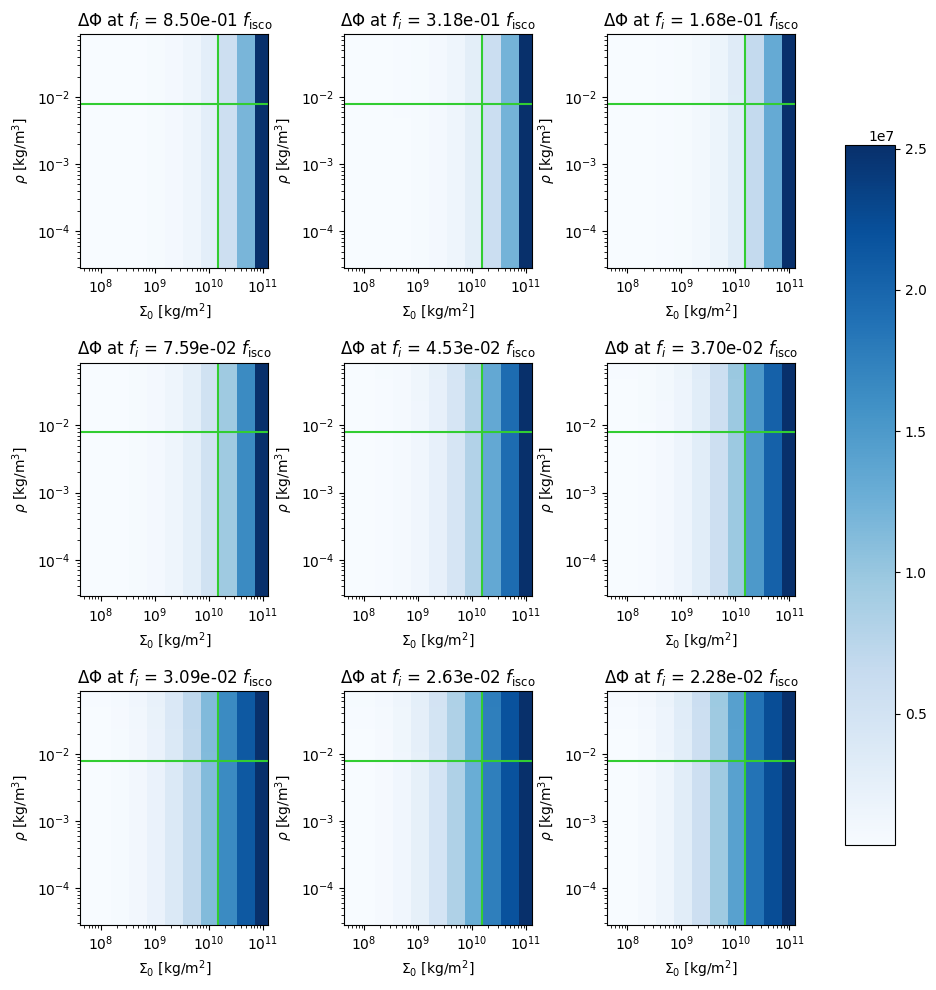

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(sigma_0, rho_s  * m_sun / (pc)**3, delta_all[:, :, i], cmap='Blues') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=1.17 * 1e17 * m_sun / (pc)**3, c='limegreen', label='ref vals')
    ax.axvline(x=1.5 * 1e10, c='limegreen')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
    ax.set_title(f'$\Delta\Phi$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities.png')

plt.show()

### $\gamma$ and $\gamma_s$

In [33]:
gamma = np.linspace(-0.7, 1.5, 10)
gamma_s = np.linspace(1, 3, 10)

In [34]:
phase_model_gammas = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = gamma[i], 
    gammas = gamma_s[j], 
    rho6 =  1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(gamma))] for j in range(0, len(gamma_s))] 

In [35]:
phi_all_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_dm_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_acc_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_gw_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gammas))]  for j in range(0, len(phase_model_gammas))]

In [36]:
phi_all_gamma = np.array(phi_all_gamma)
phi_dm_gamma = np.array(phi_dm_gamma)
phi_gw_gamma = np.array(phi_gw_gamma)
phi_acc_gamma = np.array(phi_acc_gamma)

In [37]:
delta_all_g = phi_all_gamma - phi_gw_gamma
delta_acc_g = phi_acc_gamma - phi_gw_gamma
delta_dm_g = phi_dm_gamma - phi_gw_gamma

In [61]:
freqs[n_comp_to_see]/f_isco

array([0.84996054, 0.31838831, 0.16762316, 0.07589261, 0.04531044,
       0.03695853, 0.03089051, 0.02631853, 0.02280417])

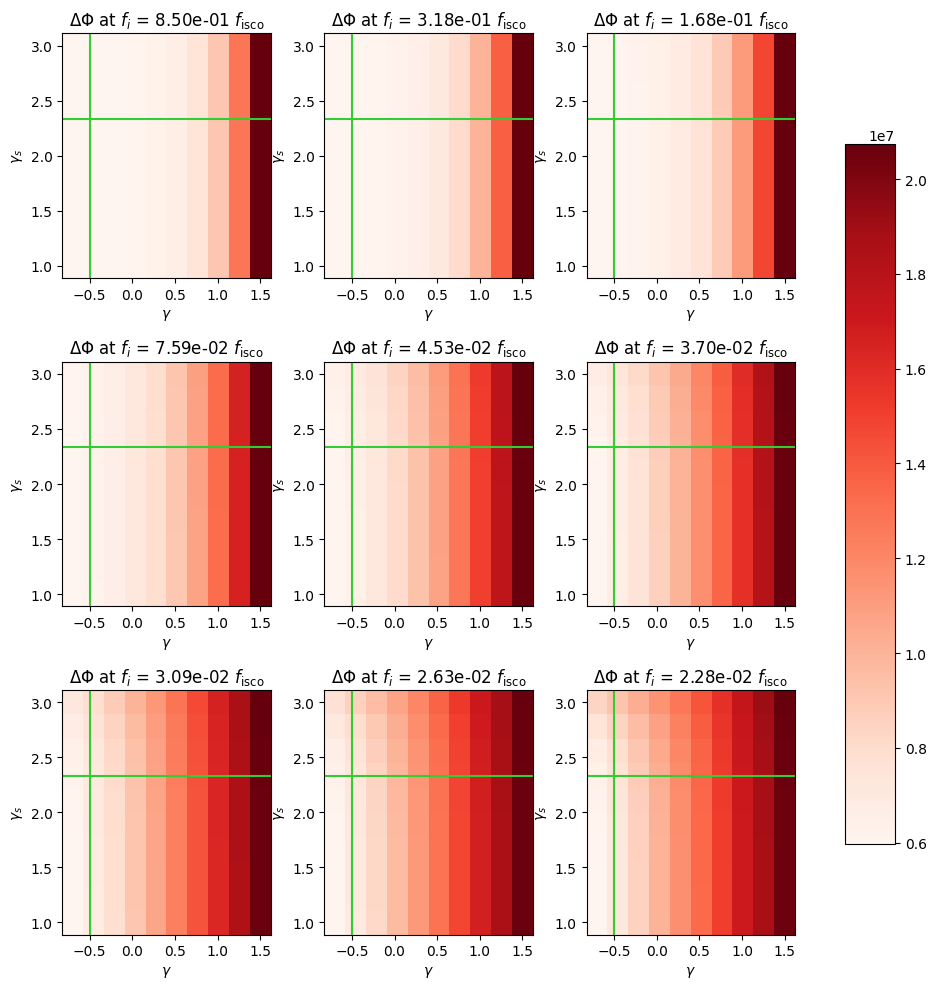

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(gamma, gamma_s, delta_all_g[:, :, i], cmap='Reds') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=7/3, c='limegreen', label='ref vals')
    ax.axvline(x=-0.5, c='limegreen')
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel(r'$\gamma_s$')
    ax.set_title(f'$\Delta\Phi$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_gammas.png')

plt.show()

# Understand the threshold in the data

The goal now is start from these plots and carry ou the following analysis in steps: 

- Fix a value for one of the quantities on the axes (for example $\gamma$); 
- Check which of the other non-selected value on the secondary axis corresponds to $\Delta\Phi < 1$; 

The final shape will determine the threshold for a given value of the parameter $\gamma$ fixed. I think I will start by fixing the first parameters to the reference values.

In [39]:
delta_all_g.shape

(10, 10, 1000)

I'll start with $\gamma$. The reference value is $\gamma = -0.5$, corresponding to the first component of the $\texttt{delta_all_g}$ tensor. I loop on the values of $\gamma_s$ at a fixed frequency to find the threshold value for $\Delta\Phi < 1$.  

In [289]:
n_comp_to_see_closer = list(range(1, 21)) #[1, 10, 20] # only close to ISCO frequencies work

In [176]:
def find_threshold(param_2_array, phase_value):
    
    '''Takes as an argument the phase value at a fixed frequency, and a fixed parameter of two (shape = [n_components_parameter2])
    Returns the optimal value if found to satisfy condition, else the first element of array & error message.'''
    
    cutoff = np.where(phase_value < 1)[0]
    
    if cutoff.size == 0:
        
        print('No optimal value found --> returning first component of params array.')
        
        return param_2_array[0]
    
    cutoff = np.where(phase_value < 1)[0][-1]
    
    return param_2_array[cutoff]

### Fix $\gamma$, find $\gamma_s$

In [283]:
gamma_s_optimal = [find_threshold(gamma_s, delta_all_g[0, :, i]) for i in n_comp_to_see_closer]

### Note:

One can see how the treshold is getting smaller as the frequencies are increasing, so for the sake of representation I chose to only plot the "maximal" threshold in which all the others are encapsuled.

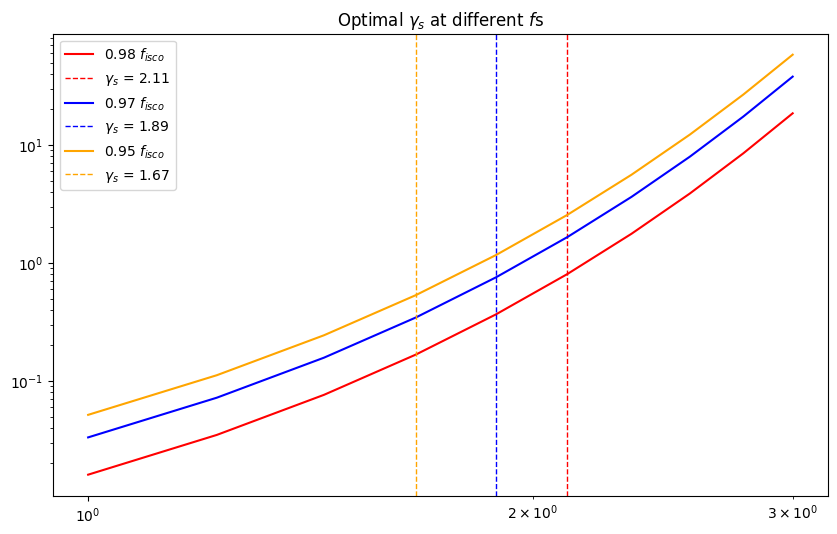

In [284]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.loglog(gamma_s, delta_all_g[0, :, n_comp_to_see_closer[i]], label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    plt.axvline(x=gamma_s_optimal[i], linestyle='--', linewidth=1, label=f'$\gamma_s$ = {gamma_s_optimal[i]:.2f}', c=colors[i])
    
plt.legend()
plt.title('Optimal $\gamma_s$ at different $f$s')
plt.show()

I think it is better to print out a table with the values with this format: 


$$|| \ \ \text{freqs} \ \ || \ \ \gamma_s \ \ ||$$

In [285]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2f}".format(gamma_s_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt gamma_s']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-------------+
| f/f_isco | opt gamma_s |
+----------+-------------+
|   0.98   |    2.11     |
|   0.97   |    1.89     |
|   0.95   |    1.67     |
|   0.94   |    1.67     |
|   0.92   |    1.67     |
|   0.91   |    1.44     |
|   0.89   |    1.44     |
|   0.88   |    1.44     |
|   0.86   |    1.44     |
|   0.85   |    1.22     |
|   0.84   |    1.22     |
|   0.82   |    1.22     |
|   0.81   |    1.22     |
|   0.80   |    1.22     |
|   0.79   |    1.22     |
|   0.78   |    1.22     |
|   0.77   |    1.00     |
|   0.76   |    1.00     |
|   0.74   |    1.00     |
|   0.73   |    1.00     |
+----------+-------------+


Having too little points to plot histogram, I plot the optimal values given a frequency:

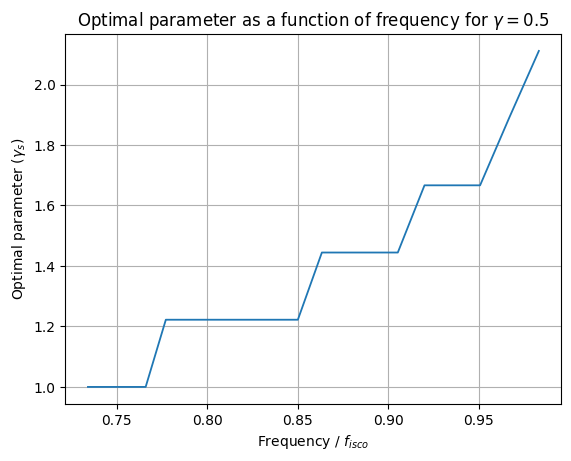

In [286]:
plt.plot(freqs[n_comp_to_see_closer] / f_isco, gamma_s_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\gamma = 0.5$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel('Optimal parameter ($\gamma_s$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

### Fix $\gamma_s$, find $\gamma$

In [220]:
gamma_s # 6 index

array([1.        , 1.22222222, 1.44444444, 1.66666667, 1.88888889,
       2.11111111, 2.33333333, 2.55555556, 2.77777778, 3.        ])

In [290]:
gamma_optimal = [find_threshold(gamma, delta_all_g[:, 6, i]) for i in n_comp_to_see_closer]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

In [291]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2f}".format(gamma_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt gamma']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-----------+
| f/f_isco | opt gamma |
+----------+-----------+
|   0.98   |   -0.70   |
|   0.97   |   -0.70   |
|   0.95   |   -0.70   |
|   0.94   |   -0.70   |
|   0.92   |   -0.70   |
|   0.91   |   -0.70   |
|   0.89   |   -0.70   |
|   0.88   |   -0.70   |
|   0.86   |   -0.70   |
|   0.85   |   -0.70   |
|   0.84   |   -0.70   |
|   0.82   |   -0.70   |
|   0.81   |   -0.70   |
|   0.80   |   -0.70   |
|   0.79   |   -0.70   |
|   0.78   |   -0.70   |
|   0.77   |   -0.70   |
|   0.76   |   -0.70   |
|   0.74   |   -0.70   |
|   0.73   |   -0.70   |
+----------+-----------+


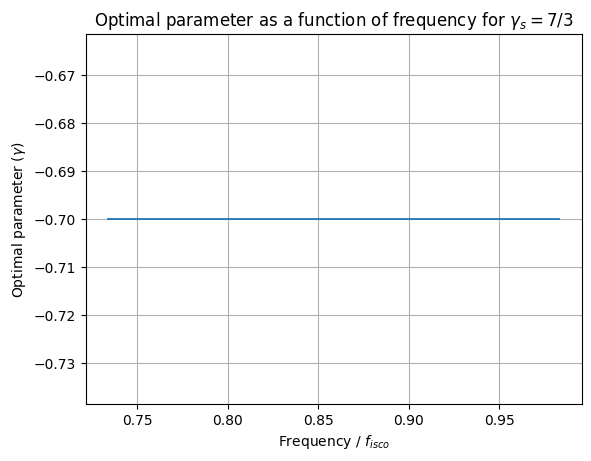

In [292]:
plt.plot(freqs[n_comp_to_see_closer] / f_isco, gamma_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\gamma_s = 7/3$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel('Optimal parameter ($\gamma$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

### Fix $\Sigma_0$, vary $\rho_{\mathrm{dm}}$

In [293]:
sigma_0 # 6 index

array([1.00000000e+08, 2.15443469e+08, 4.64158883e+08, 1.00000000e+09,
       2.15443469e+09, 4.64158883e+09, 1.00000000e+10, 2.15443469e+10,
       4.64158883e+10, 1.00000000e+11])

In [294]:
rho_dm_optimal = [find_threshold(rho_s, delta_all[6, :, i]) for i in n_comp_to_see_closer]

In [295]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2e}".format(rho_dm_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt rho_dm']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+------------+
| f/f_isco | opt rho_dm |
+----------+------------+
|   0.98   |  4.64e+16  |
|   0.97   |  2.15e+16  |
|   0.95   |  1.00e+16  |
|   0.94   |  1.00e+16  |
|   0.92   |  1.00e+16  |
|   0.91   |  4.64e+15  |
|   0.89   |  4.64e+15  |
|   0.88   |  4.64e+15  |
|   0.86   |  4.64e+15  |
|   0.85   |  4.64e+15  |
|   0.84   |  2.15e+15  |
|   0.82   |  2.15e+15  |
|   0.81   |  2.15e+15  |
|   0.80   |  2.15e+15  |
|   0.79   |  2.15e+15  |
|   0.78   |  2.15e+15  |
|   0.77   |  2.15e+15  |
|   0.76   |  2.15e+15  |
|   0.74   |  1.00e+15  |
|   0.73   |  1.00e+15  |
+----------+------------+


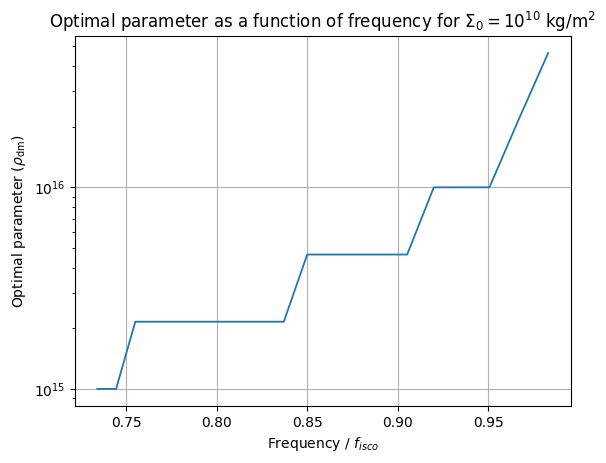

In [296]:
plt.semilogy(freqs[n_comp_to_see_closer] / f_isco, rho_dm_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\Sigma_0 = 10^{10}$ kg/m$^2$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\rho_{\mathrm{dm}}$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

### Fix $\rho_{\mathrm{dm}}$, vary $\Sigma_0$

In [297]:
sigma_0_optimal = [find_threshold(sigma_0, delta_all[:, 6, i]) for i in n_comp_to_see_closer]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

In [298]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2e}".format(sigma_0_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt sigma_0']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-------------+
| f/f_isco | opt sigma_0 |
+----------+-------------+
|   0.98   |  1.00e+08   |
|   0.97   |  1.00e+08   |
|   0.95   |  1.00e+08   |
|   0.94   |  1.00e+08   |
|   0.92   |  1.00e+08   |
|   0.91   |  1.00e+08   |
|   0.89   |  1.00e+08   |
|   0.88   |  1.00e+08   |
|   0.86   |  1.00e+08   |
|   0.85   |  1.00e+08   |
|   0.84   |  1.00e+08   |
|   0.82   |  1.00e+08   |
|   0.81   |  1.00e+08   |
|   0.80   |  1.00e+08   |
|   0.79   |  1.00e+08   |
|   0.78   |  1.00e+08   |
|   0.77   |  1.00e+08   |
|   0.76   |  1.00e+08   |
|   0.74   |  1.00e+08   |
|   0.73   |  1.00e+08   |
+----------+-------------+


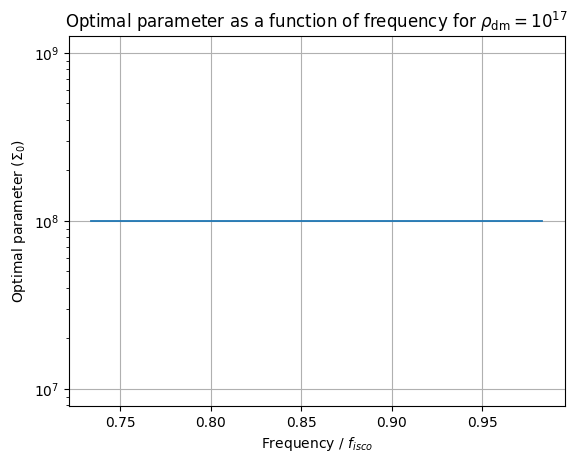

In [299]:
plt.semilogy(freqs[n_comp_to_see_closer] / f_isco, sigma_0_optimal, linewidth=1.3)
plt.title(r'Optimal parameter as a function of frequency for $\rho_{\mathrm{dm}} = 10^{17}$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\Sigma_0$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Checking the accretion parameters change with respect to dark matter ones

The accretion optimal parameters seem to be okay in detection with respect to fixed reference values of the dark matter profile. However, I want to check if changing the dark matter's density to larger or lower values affects this behavior. 

In [328]:
# Create array for each evaluation

gamma_optimal_i = np.array([[find_threshold(gamma, delta_all_g[:, j, i]) for i in n_comp_to_see_closer] for j in range(0, len(gamma_s))])

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

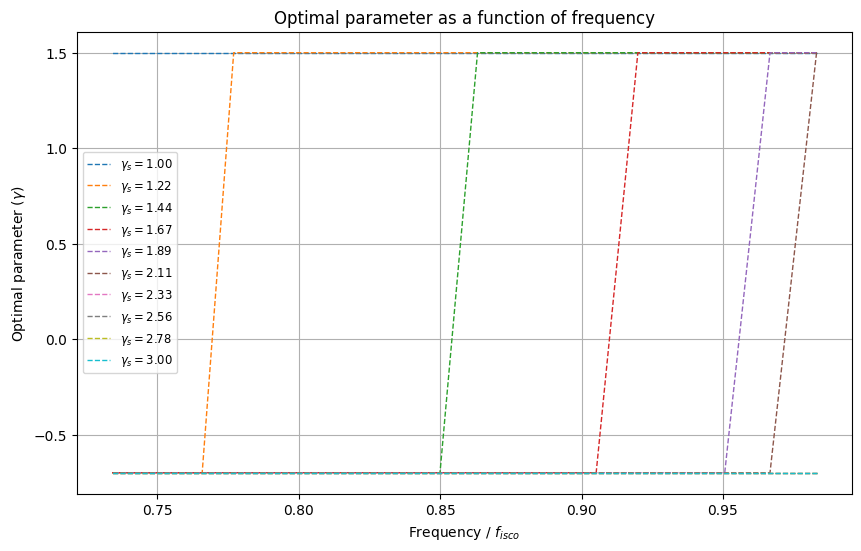

In [301]:
plt.figure(figsize=(10, 6))

for i in range(0, len(gamma_optimal_i)):

    plt.plot(freqs[n_comp_to_see_closer] / f_isco, gamma_optimal_i[i], linewidth=1, label=f'$\gamma_s = {gamma_s[i]:.2f}$', linestyle='--')
    
plt.title(r'Optimal parameter as a function of frequency')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\gamma$)')
plt.grid(True)  # Add grid lines for better readability
plt.legend(fontsize='small')
plt.show()

In [302]:
# Create array for each evaluation

sigma_0_optimal_i = [[find_threshold(sigma_0, delta_all_g[:, j, i]) for i in n_comp_to_see_closer] for j in range(0, len(rho_s))]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

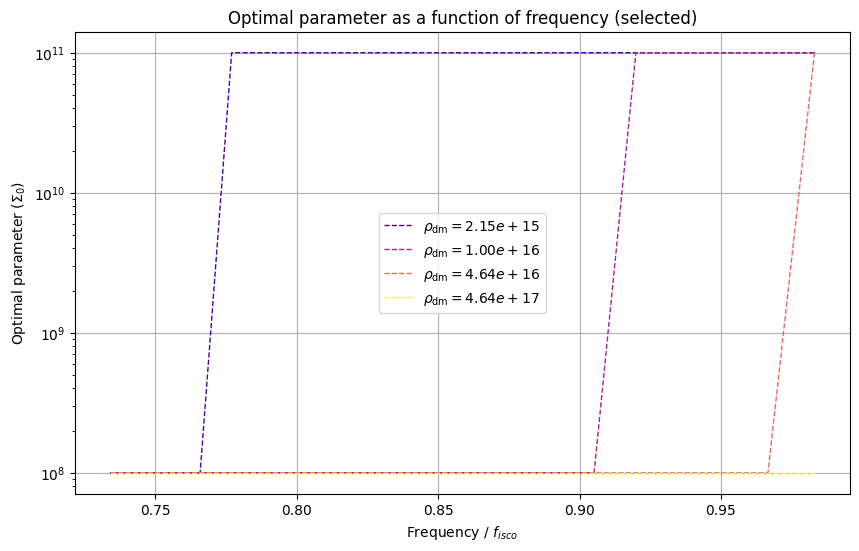

In [338]:
cmap = plt.get_cmap('plasma')
selected_vals = [1, 3, 5, 8]

plt.figure(figsize=(10, 6))

for i in selected_vals:
    
    color = cmap(0.5 * i / len(gamma_optimal_i[selected_vals])) 
    plt.plot(freqs[n_comp_to_see_closer] / f_isco, sigma_0_optimal_i[i], linewidth=1, linestyle='--', label=fr'$\rho_{{\mathrm{{dm}}}} = {rho_s[i]:.2e}$', color=color)
    
plt.title(r'Optimal parameter as a function of frequency (selected)')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\Sigma_0$)')
plt.yscale('log')
plt.grid(True)  # Add grid lines for better readability
plt.legend(fontsize='medium')
plt.show()

Do some other verifications:

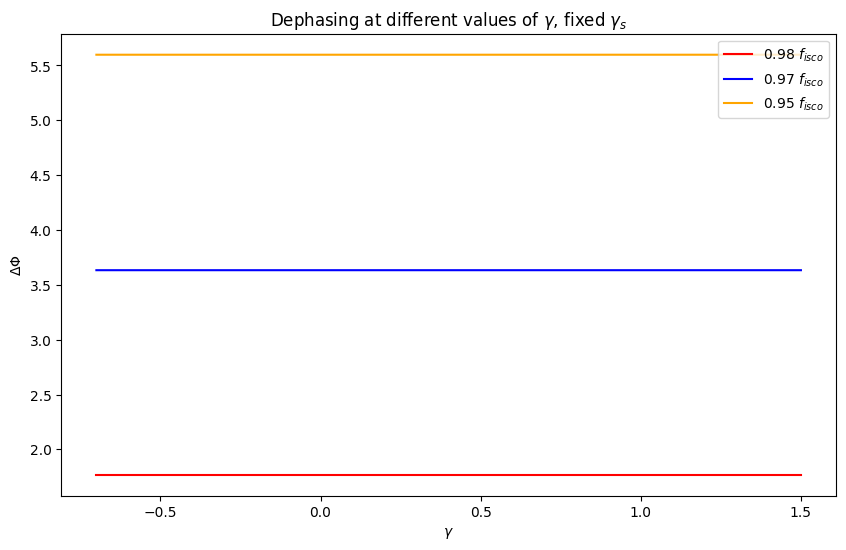

In [313]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.plot(gamma, delta_all_g[:, 6, n_comp_to_see_closer[i]], label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    
plt.xlabel('$\gamma$')
plt.ylabel('$\Delta\Phi$')
plt.legend()
plt.title('Dephasing at different values of $\gamma$, fixed $\gamma_s$')
plt.savefig('dephasing-test-gamma.png')
plt.show()

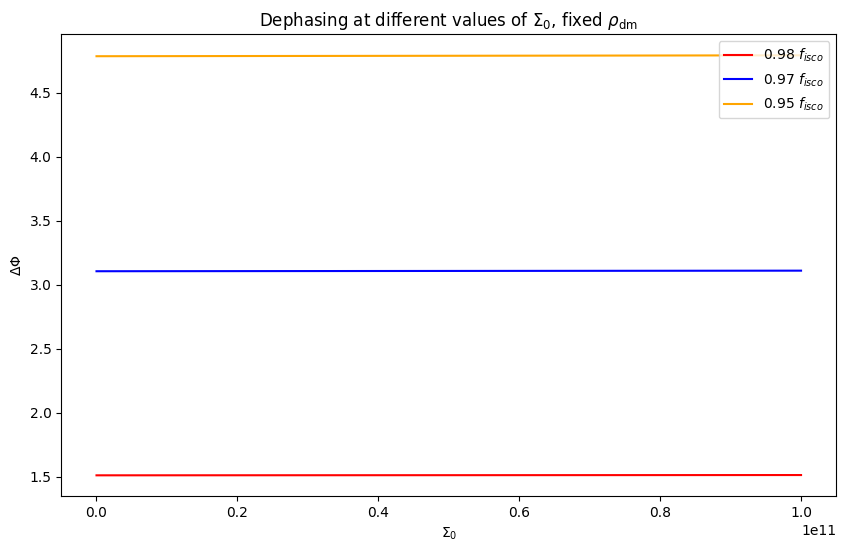

In [314]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.plot(sigma_0, delta_all[:, 6, n_comp_to_see_closer[i]], label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    
plt.xlabel('$\Sigma_0$')
plt.ylabel('$\Delta\Phi$')
plt.legend()
plt.title(r'Dephasing at different values of $\Sigma_0$, fixed $\rho_{\mathrm{dm}}$')
plt.savefig('dephasing-test-sigma_0.png')
plt.show()

It seems that if we fix the value for the dark matter spike, the change on the dephasing given by the accretion disk is relatively small for a fixed frequency close to isco.

## Detection time treshold

The idea that is in the below lines is the following: for a specific environment, e.g. only accretion, or only dark matter, I evaluate the $f_{\mathrm{thresh}}$ at different parameters values (for example change $\Sigma_0$, or $\rho_{\mathrm{dm}}$). This is the frequency at which I see that the dephasing value is such that $\Delta\Phi < 1$. I then plot for each parameter value the time until which I expect to be able to spot the difference with the vacuum case.  

### Accretion disk

- Start with $\Sigma_0$.

In [347]:
phase_model_dense_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0[i], 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = 1.5e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0))] 

In [348]:
phi_acc_dense_2 = np.array([(phase_model_dense_2[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_dense_2))])
phi_gw_dense_2 = np.array([(phase_model_dense_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense_2))])

In [353]:
delta_acc_2 = phi_acc_dense_2 - phi_gw_dense_2

In [360]:
def find_threshold_freq(freqs, phase_value):
    
    '''Takes as an argument the phase value at a fixed frequency, and a fixed parameter of two (shape = [n_components_parameter2])
    Returns the optimal value if found to satisfy condition, else the first element of array & error message.'''
    
    cutoff = np.where(phase_value < 1)[0]
    
    if cutoff.size == 0:
        
        print('No optimal value found --> returning first component of data array.')
        
        return phase_value[0]
    
    cutoff = np.where(phase_value < 1)[0][-1]
    
    return freqs[cutoff]

In [365]:
freqs_detection = np.array([find_threshold_freq(freqs, delta_acc_2[i]) for i in range(0, len(delta_acc_2))])

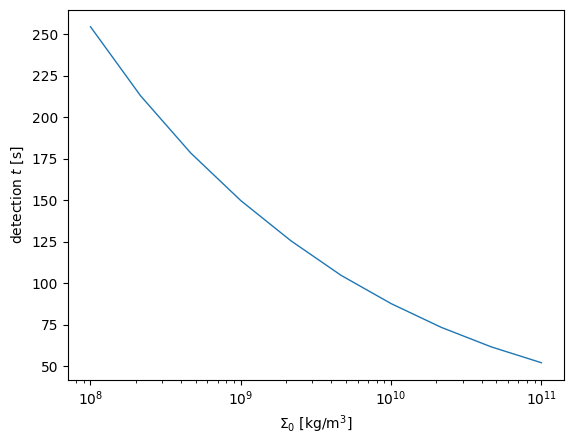

In [367]:
plt.semilogx(sigma_0, 1/freqs_detection, linestyle='-', linewidth=1)

plt.xlabel('$\Sigma_0$ [kg/m$^3$]')
plt.ylabel('detection $t$ [s]')
plt.show()

- Continue with $\gamma$.

In [372]:
phase_model_gamma_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = gamma[i], 
    gammas = 7/3, 
    rho6 = 1.5e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(gamma))] 

In [373]:
phi_acc_gamma_2 = np.array([(phase_model_gamma_2[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_gamma_2))])
phi_gw_gamma_2 = np.array([(phase_model_gamma_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gamma_2))])

In [374]:
delta_gamma_2 = phi_acc_gamma_2 - phi_gw_gamma_2

In [376]:
freqs_detection_gamma = np.array([find_threshold_freq(freqs, delta_gamma_2[i]) for i in range(0, len(delta_gamma_2))])

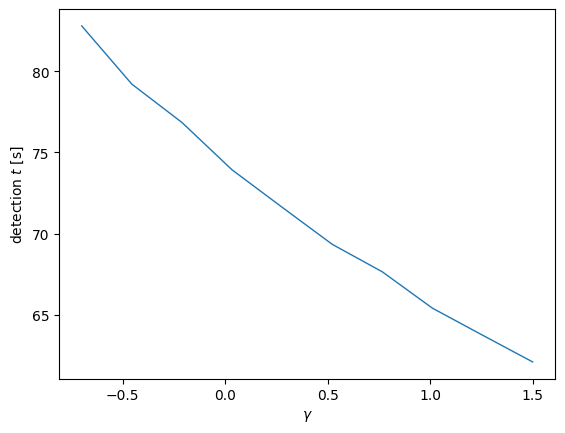

In [379]:
plt.plot(gamma, 1/freqs_detection_gamma, linestyle='-', linewidth=1)

plt.xlabel('$\gamma$')
plt.ylabel('detection $t$ [s]')
plt.show()

In [ ]:
# Maybe do the same for dm as well?